In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [15]:
df = pd.read_csv('..\\Data\\Discharge_670.csv')

data = np.array([])
for column in df.columns[1:]:
    data = np.append(data, df[column].values)

df = pd.DataFrame(data, columns=["discharge"])
date = pd.date_range(start="1965-01-01", periods=len(data), freq="D")
df["Date"] = date
df = df.set_index("Date")

# df = df[df.index > "2000-01-01"]

display(df.head())

,discharge
Date,
1965-01-01,61.793513
1965-01-02,61.793513
1965-01-03,61.793513
1965-01-04,61.793513
1965-01-05,60.690057


,discharge,cum,demand_cum,shortage
Date,,,,
1,4.534098e+08,4.534098e+08,6.092776e+08,1.558679e+08
2,5.117705e+08,9.651803e+08,1.218555e+09,2.533750e+08
3,5.512859e+08,1.516466e+09,1.827833e+09,3.113668e+08
4,6.893799e+08,2.205846e+09,2.437111e+09,2.312646e+08
5,8.089902e+08,3.014836e+09,3.046388e+09,3.155201e+07


311366838.9313228


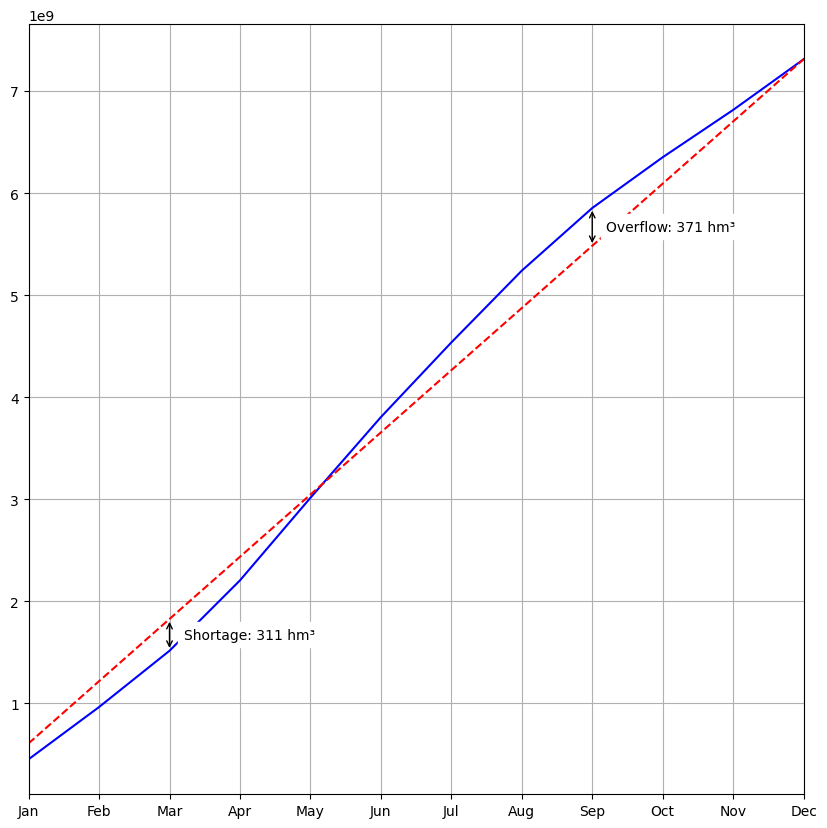

In [36]:
df_aten = df.resample("ME").mean()
df_aten = df_aten.groupby(df_aten.index.month).mean()
df_aten["discharge"] = df_aten["discharge"] * 3600 * 24 * 30.44  # m3/month
df_aten["cum"] = df_aten["discharge"].cumsum()
demand = df_aten["discharge"].mean()
df_aten["demand"] = demand
df_aten["demand_cum"] = df_aten["demand"].cumsum()
df_aten.drop(columns=["demand"], inplace=True)
df_aten["shortage"] = df_aten["demand_cum"] - df_aten["cum"]
display(df_aten.head())


shortage = df_aten["shortage"].max()
shortage_date = df_aten["shortage"].idxmax()
overflow = -df_aten["shortage"].min()
overflow_date = df_aten["shortage"].idxmin()
print(shortage)

fig, ax = plt.subplots(figsize=(10, 10))

# ax.plot(df_aten.index, df_aten["discharge"], color="black", label="Daily Discharge")

ax.plot(df_aten.index, df_aten["cum"], color="blue", label="Cumulative Discharge")
ax.plot(df_aten.index, df_aten["demand_cum"], "r--", label="Cumulative Demand")
ax.set_xlim(1, 12)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(
    [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ]
)
ax.annotate('',
            xy=(shortage_date, df_aten.loc[shortage_date, "cum"]),
            xytext=(shortage_date, df_aten.loc[shortage_date, "demand_cum"]),
            arrowprops=dict(arrowstyle='<->', color='black', lw=1)
           )
ax.text(shortage_date + 0.2, (df_aten.loc[shortage_date, "cum"] + df_aten.loc[shortage_date, "demand_cum"]) / 2,
        f'Shortage: {shortage/10**6:,.0f} hm³', color='black', va='center', backgroundcolor='white')

ax.annotate('',
            xy=(overflow_date, df_aten.loc[overflow_date, "cum"]),
            xytext=(overflow_date, df_aten.loc[overflow_date, "demand_cum"]),
            arrowprops=dict(arrowstyle='<->', color='black', lw=1)
           )
ax.text(overflow_date + 0.2, (df_aten.loc[overflow_date, "cum"] + df_aten.loc[overflow_date, "demand_cum"]) / 2,
        f'Overflow: {overflow/10**6:,.0f} hm³', color='black', va='center', backgroundcolor='white')  

ax.grid()

In [ ]:
df["cum"] = df["discharge"].cumsum()

avg_discharge = df["discharge"].mean()
df["dis_avg"] = avg_discharge
df["cum_avg"] = df["dis_avg"].cumsum()
df["norm"] = df["cum"] - df["cum_avg"]
df.drop(columns="dis_avg", inplace=True)

1997 1996


,cum,norm,diff
Date,,,
1965,7.027405e+09,6.609392e+08,NaN
1966,1.372391e+10,2.454344e+08,-4.155048e+08
1967,1.896469e+10,-1.360181e+09,-1.605616e+09
1968,2.610098e+10,-1.763426e+09,-4.032444e+08
1969,3.323815e+10,-1.987581e+09,-2.241555e+08


,cum,norm,diff
Date,,,
1965,7.027405e+09,6.609392e+08,NaN
1966,1.372391e+10,2.454344e+08,-4.155048e+08
1967,1.896469e+10,-1.360181e+09,-1.605616e+09
1968,2.610098e+10,-1.763426e+09,-4.032444e+08
1969,3.323815e+10,-1.987581e+09,-2.241555e+08


Required Volume: 3830.13 million cubic meters


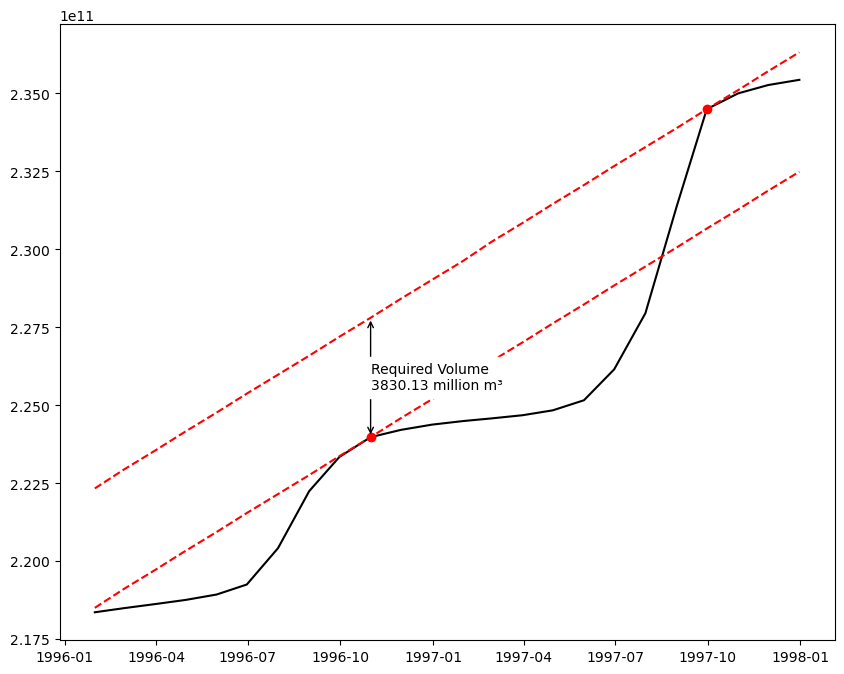

In [ ]:
df_max = df.groupby(df.index.year).max()
df_max.drop(columns=["discharge", "cum_avg"], inplace=True)
df_max["diff"] = df_max["norm"].diff()

ye_1 = df_max["diff"].idxmax()
ye_0 = df_max["diff"].idxmax() - 1

diff_max = df_max["diff"].max()

print(ye_1, ye_0)
display(df_max.head())

df_red = df[(df.index.year >= ye_0) & (df.index.year <= ye_1)].copy()
df_red["max_y"] = df_red["norm"].groupby(df_red.index.year).transform('max')
df_red["min_y"] = df_red["norm"].groupby(df_red.index.year).transform('min')
df_red["upline"] = df_red["cum_avg"] + df_red["norm"].max()
df_red["loline"] = df_red["cum_avg"] + df_red[df_red.index.year == ye_0]["norm"].max()

display(df_max.head())

max_dates = df_red.groupby(df_red.index.year)['norm'].idxmax()

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df_red.index, df_red["cum"], label="Normalized Discharge", color="black")
ax.plot(max_dates, df_red.loc[max_dates, "cum"], 'ro', label="Max Point")
ax.plot(df_red.index, df_red["upline"], 'r--', label="Max Line")
ax.plot(df_red.index, df_red["loline"], 'r--', label="Min Line")
ax.annotate(
    '', 
    xy=(max_dates.min(), df_red.loc[max_dates.min(), "upline"]),
    xytext=(max_dates.min(), df_red.loc[max_dates.min(), "loline"]),
    arrowprops=dict(arrowstyle='<->', color='black', lw=1)
)
ax.text(
    max_dates.min(), 
    (df_red.loc[max_dates.min(), "upline"] + df_red.loc[max_dates.min(), "loline"]) / 2,
    f'Required Volume\n{(df_red["upline"].max() - df_red["loline"].max())/1e6:.2f} million m³',
    color='black',
    fontsize=10,
    ha='left',
    va='center',
    backgroundcolor='white'
)

req_vol = df_red["upline"].max() - df_red["loline"].max()

print(f"Required Volume: {req_vol / 1e6:.2f} million cubic meters")


,discharge,cum,cum_avg,norm,min_y,max_y,diff_y
Date,,,,,,,
1965-01-31,1.514930e+08,1.514930e+08,6.082553e+08,-4.567623e+08,-2.320688e+09,6.609392e+08,2.981628e+09
1965-02-28,1.172855e+08,2.687785e+08,1.216511e+09,-9.477321e+08,-2.320688e+09,6.609392e+08,2.981628e+09
1965-03-31,1.191160e+08,3.878945e+08,1.824766e+09,-1.436871e+09,-2.320688e+09,6.609392e+08,2.981628e+09
1965-04-30,1.443330e+08,5.322275e+08,2.433021e+09,-1.900794e+09,-2.320688e+09,6.609392e+08,2.981628e+09
1965-05-31,1.883604e+08,7.205879e+08,3.041276e+09,-2.320688e+09,-2.320688e+09,6.609392e+08,2.981628e+09


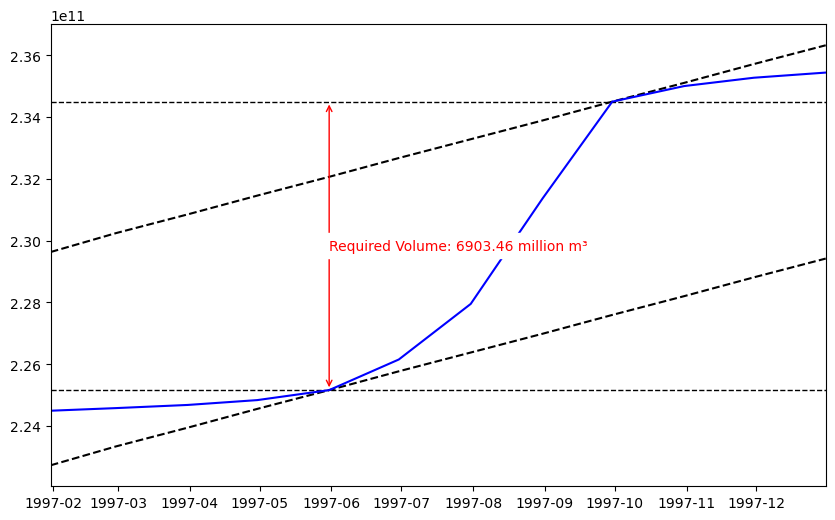

In [ ]:
df["min_y"] = df["norm"].groupby(df.index.year).transform("min")
df["max_y"] = df["norm"].groupby(df.index.year).transform("max")
df["diff_y"] = abs(df["max_y"] - df["min_y"])

maxdiff = df["diff_y"].max()
maxdiff_date = df[df["diff_y"] == maxdiff].index[0].year

df_max = df.loc[df.index.year == maxdiff_date].copy()

df_max["minline"] = df_max["cum_avg"] + df_max["min_y"]
df_max["maxline"] = df_max["cum_avg"] + df_max["max_y"]

mindate = df_max[df_max["norm"] == df_max["min_y"]].index[0]
maxdate = df_max[df_max["norm"] == df_max["max_y"]].index[0]
maxval = df_max.loc[maxdate, "cum"]
minval = df_max.loc[mindate, "cum"]


fig, ax = plt.subplots(figsize=(10, 6))
ax.axhline(minval, color="black", linestyle="--", lw = 1)
ax.axhline(maxval, color="black", linestyle="--", lw = 1)
ax.plot(df_max.index, df_max["minline"],"k--", label="Minimum Line")
ax.plot(df_max.index, df_max["maxline"],"k--", label="Maximum Line")
ax.plot(df_max.index, df_max["cum"], label="Normalized Cumulative Discharge", color="blue")
ax.set_xlim([df_max.index.min(), df_max.index.max()])
# ax.vlines(mindate, ymin=minval, ymax=maxval, color='red', linestyle='--', label='Min Date')
# print(f"Maximum yearly range in normalized cumulative discharge: {maxdiff:.2f} m³")
ax.annotate(
    '', 
    xy=(mindate, maxval), 
    xytext=(mindate, minval),
    arrowprops=dict(arrowstyle='<->', color='red', lw=1)
)
ax.text(mindate, (minval + maxval)/2, f'Required Volume: {maxdiff/1e6:.2f} million m³', color='red', fontsize=10, ha='left', va='center', backgroundcolor='white')

display(df.head())